# Road Traffic Vehicle Counting Exam

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this exam, you will use the YOLO (You Only Look Once) object detection model to analyze a video of road traffic. Your primary task is to count the number of vehicles exiting the road at each of the four exits (located at the top, bottom, left, and right of the frame). The video for this task is provided at `Datasets/YOLO_Exam_Video.mp4`.

## Objectives
- Load and process the video using OpenCV.
- Utilize the YOLO model to detect vehicles in each frame.
- Manipulate the video frames using OpenCV.
- Track vehicles as they move across the video frames.
- Count the number of vehicles exiting via the top street.
- Count the number of vehicles exiting via the bottom street.
- Count the number of vehicles exiting via the left street.
- Count the number of vehicles exiting via the right street.


## Setup Environment

Before you begin, ensure you have the necessary libraries installed. You will need `opencv`, and `ultralytics` among others.
If these are not installed, you should install them.

In [78]:
!pip install ultralytics -q

In [79]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow

## Load the YOLO Model

You will first need to load the YOLO model, there is a custom model for this exam called `YOLO_Model.pt` under Datasets file ⚠️ PLEASE USE THIS MODEL AND DO NOT USE ANY OTHER MODEL ⚠️.
Write the code to load the YOLO model below:

In [80]:
model_path = '/content/drive/MyDrive/Colab/T5Bootcamp/Week 6/5- Weekly Project (Sunday)/Dataset/YOLO_Model.pt'
model = YOLO(model_path)

## Prepare the Video Capture

Create a variable to capture the video frames, you can use `cv2.VideoCapture()` to achive this.

In [81]:
vid_path = '/content/YOLO_Video.mp4'
video = cv2.VideoCapture(vid_path)

## Get Video Information

You can use `cv2` library to get these information fro the `VideoCapture()` variable you created to extract these information:
* `height`: Video's height.
* `width`: Video's width.
* `fps`: Video's frames.

In [82]:
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)

## Prepare Video Writer to Store the Output

Create a variable that uses `cv2.VideoCapture()` to save the video with the bounding boxes, specified Region of Interest rectangle (ROI) and the counted vehicles on each sides. You will need to make the video with the same `fps`, `width`, `height`, and specify the codec and output path of the video.

In [92]:
output_path = '/content/output.mp4'
VIDEO_CODEC = "MP4V"
output_video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height))

## Expermint to get the `(x1, y1, x2, y2)` of the ROI

### Hint
When defining the Regions of Interest (ROIs) for detecting vehicles exiting the road, consider the coordinates that outline the relevant areas. These coordinates can be specified as `(x1, y1, x2, y2)`, where `(x1, y1)` is the top-left corner and `(x2, y2)` is the bottom-right corner of the rectangle.

Experiment with different coordinates to accurately cover the streets where vehicles exit. Visualize these ROIs by drawing rectangles on a frame of the video and adjust the coordinates as needed until you capture the desired areas effectively.

In [84]:
_, img = video.read()

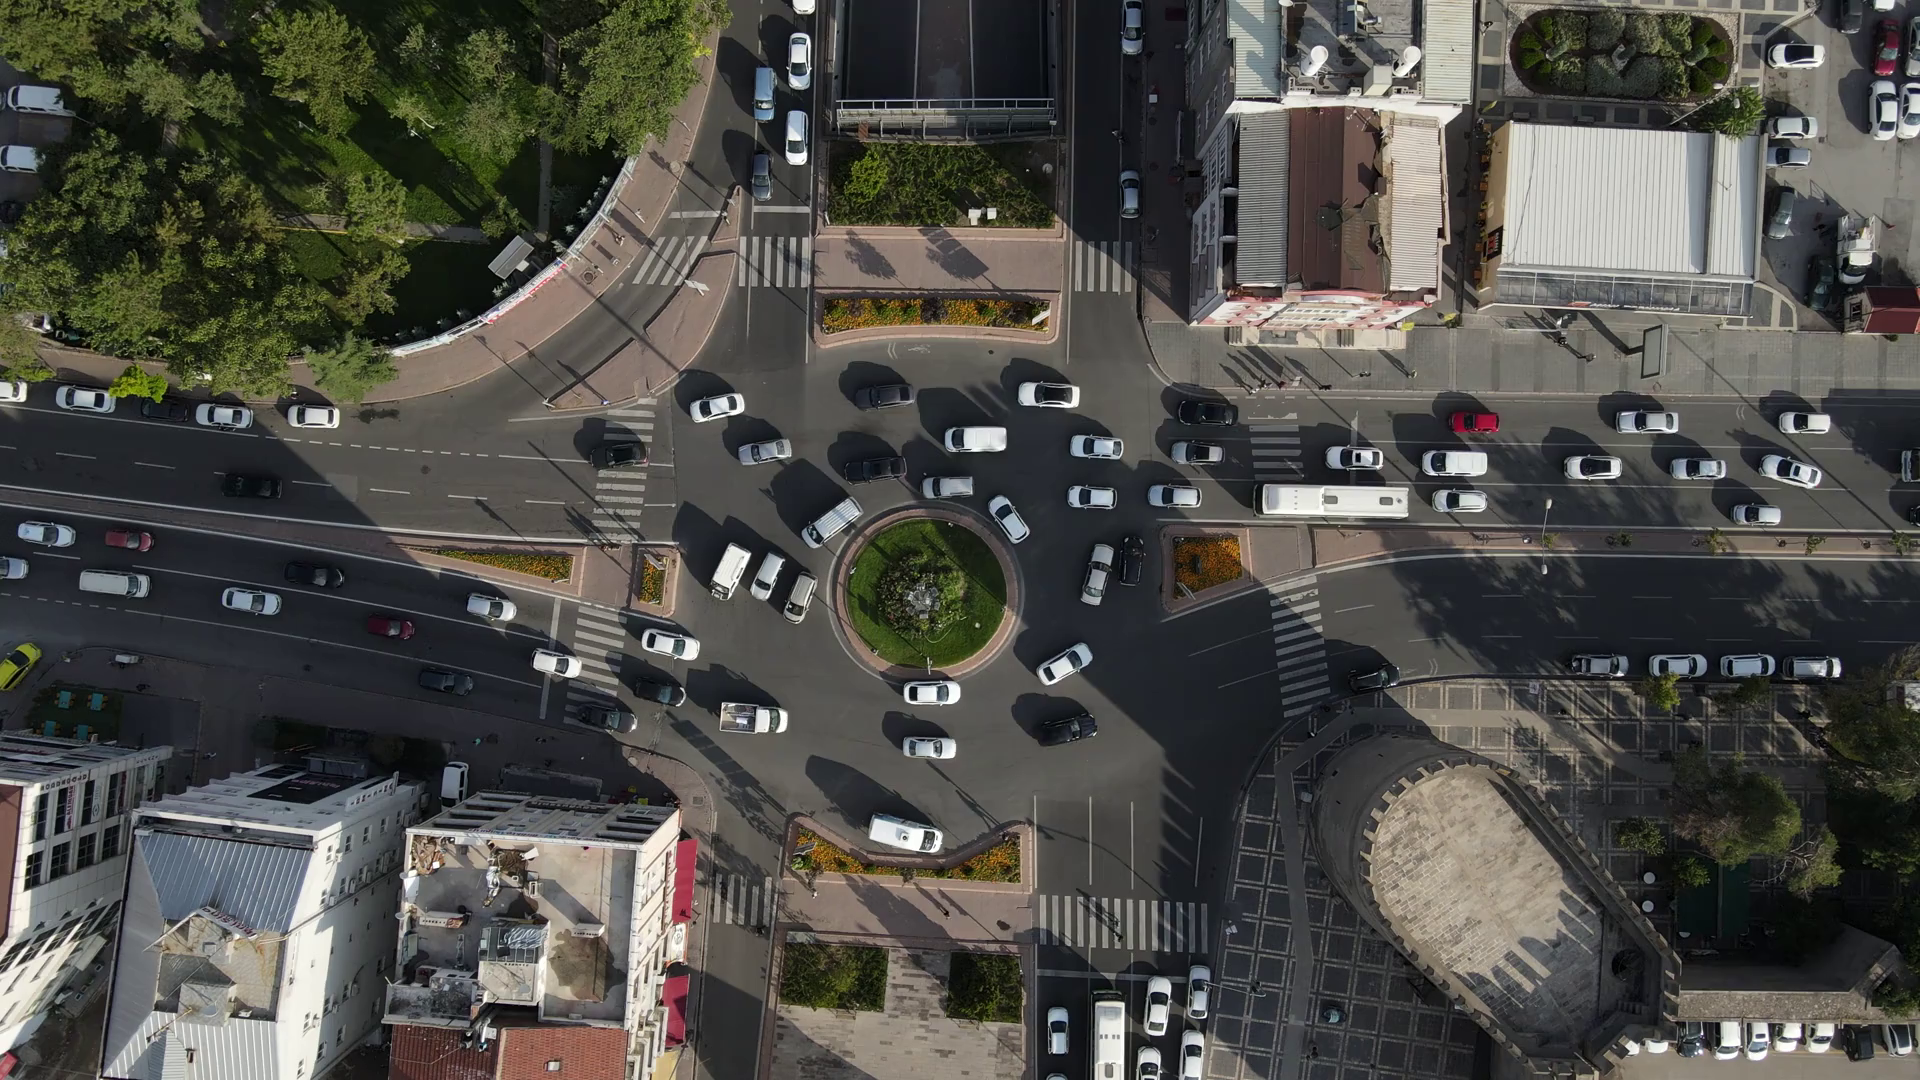

In [85]:
cv2_imshow(img)

In [86]:
print(width)
print(height)

1920
1080


In [87]:
roi_top = (int(width * 0.55), 0, int(width * 0.61), int(height * 0.33))
roi_bottom = (int(width * 0.35), int(height * 0.77), int(width * 0.41), height)
roi_left = (int(width * 0.15), int(height * 0.35), int(width * 0.3), int(height * 0.5))
roi_right = (int(width * 0.62), int(height * 0.53), int(width * 0.8), int(height * 0.66))

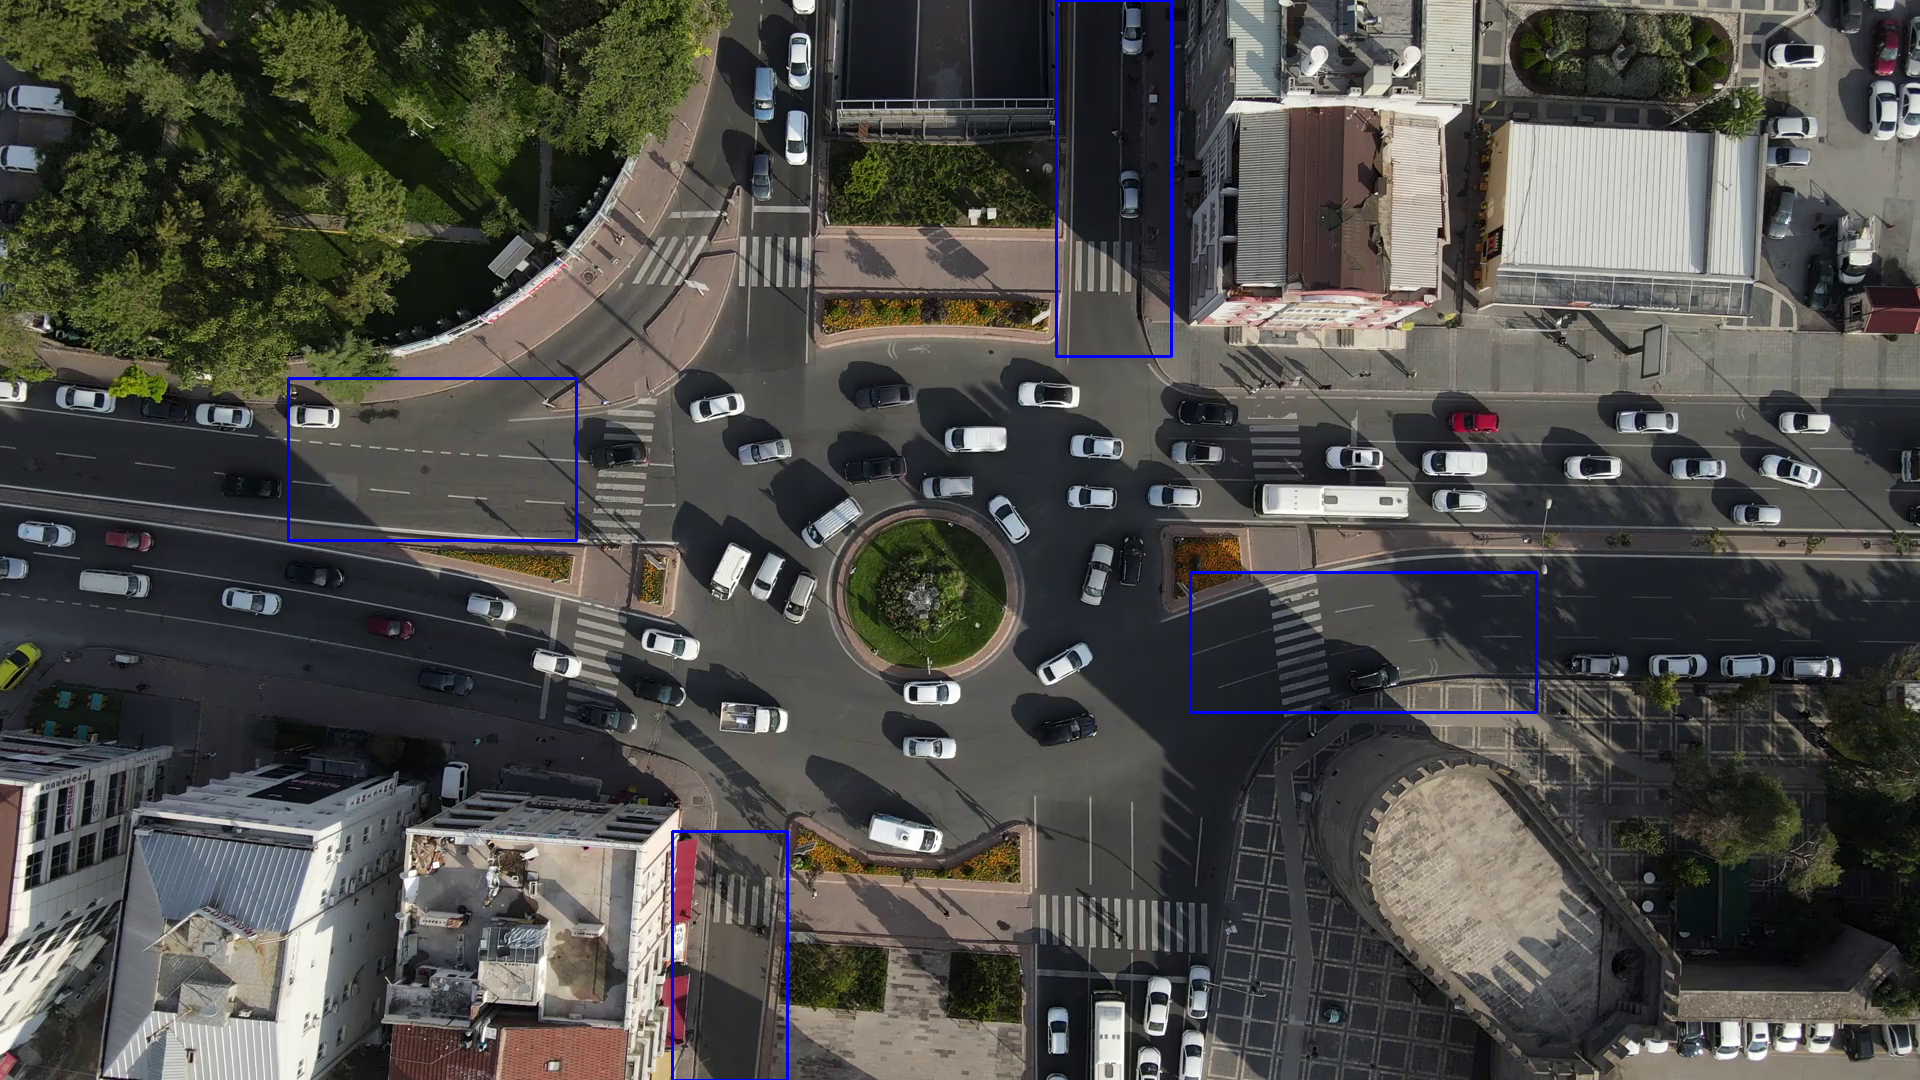

In [88]:
video = cv2.VideoCapture(vid_path)
ret, frame = video.read()

cv2.rectangle(frame, (roi_top[0], roi_top[1]), (roi_top[2], roi_top[3]), (255, 0, 0), 2)
cv2.rectangle(frame, (roi_bottom[0], roi_bottom[1]), (roi_bottom[2], roi_bottom[3]), (255, 0, 0), 2)
cv2.rectangle(frame, (roi_left[0], roi_left[1]), (roi_left[2], roi_left[3]), (255, 0, 0), 2)
cv2.rectangle(frame, (roi_right[0], roi_right[1]), (roi_right[2], roi_right[3]), (255, 0, 0), 2)

cv2_imshow(frame)


## Process Video Frames and Identify Vehicles Left the Road Form Each Street

For each frame in the video, use the YOLO model to detect and track vehicles. You will need to write a loop that processes each frame and applies the YOLO model.

In each frame, after detecting the vehicles, determine whether they exited the road via the top, bottom, left, or right street. You can use the positions of the bounding boxes provided by YOLO to do this.

- The video should display bounding boxes around the detected objects.
- The video should display your name on the top.
- It should display the calculated center of each vehicle.
- The video should display the confidence score, alongside the object ID and class ID of each detected and tracked object.
- The video should display the rectangles representing the regions where you count the vehicles that have crossed and exited.
- The video should display the number of vehicles that exited via the top street.
- The video should display the number of vehicles that exited via the bottom street.
- The video should display the number of vehicles that exited via the left street.
- The video should display the number of vehicles that exited via the right street.

In [89]:
import torch
'cuda:0' if torch.cuda.is_available() else 'cpu'

'cuda:0'

In [93]:
video = cv2.VideoCapture(vid_path)

In [94]:
exit_counts = {'top': 0, 'bottom': 0, 'left': 0, 'right': 0}
tracked_ids = {'top': set(), 'bottom': set(), 'left': set(), 'right': set()}
# c = 0

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    results = model.track(frame, persist=True, verbose=False, device=0)

    boxes = results[0].boxes.xywh.cpu().numpy()
    track_ids = results[0].boxes.id.int().cpu().tolist()
    clss = results[0].boxes.cls.cpu().tolist()
    confs = results[0].boxes.conf.cpu().tolist()

    for i, box in enumerate(boxes):
        x, y, w, h = map(int, box[:4])
        x1, y1 = int(x - w / 2), int(y - h / 2)
        x2, y2 = int(x + w / 2), int(y + h / 2)
        center_x, center_y = x, y
        track_id = track_ids[i]
        conf = confs[i]
        cls = clss[i]

        if roi_top[1] < center_y < roi_top[3] and roi_top[0] < center_x < roi_top[2]:
            if track_id not in tracked_ids['top']:
                exit_counts['top'] += 1
                tracked_ids['top'].add(track_id)
        elif roi_bottom[1] < center_y < roi_bottom[3] and roi_bottom[0] < center_x < roi_bottom[2]:
            if track_id not in tracked_ids['bottom']:
                exit_counts['bottom'] += 1
                tracked_ids['bottom'].add(track_id)
        elif roi_left[1] < center_y < roi_left[3] and roi_left[0] < center_x < roi_left[2]:
            if track_id not in tracked_ids['left']:
                exit_counts['left'] += 1
                tracked_ids['left'].add(track_id)
        elif roi_right[1] < center_y < roi_right[3] and roi_right[0] < center_x < roi_right[2]:
            if track_id not in tracked_ids['right']:
                exit_counts['right'] += 1
                tracked_ids['right'].add(track_id)

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'Conf:{conf:.2f} ID:{track_id} Class:{cls}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    cv2.rectangle(frame, (roi_top[0], roi_top[1]), (roi_top[2], roi_top[3]), (255, 0, 0), 2)
    cv2.rectangle(frame, (roi_bottom[0], roi_bottom[1]), (roi_bottom[2], roi_bottom[3]), (255, 0, 0), 2)
    cv2.rectangle(frame, (roi_left[0], roi_left[1]), (roi_left[2], roi_left[3]), (255, 0, 0), 2)
    cv2.rectangle(frame, (roi_right[0], roi_right[1]), (roi_right[2], roi_right[3]), (255, 0, 0), 2)

    cv2.putText(frame, f'{exit_counts["top"]}', (int(width * 0.552), int(height * 0.322)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    cv2.putText(frame, f'{exit_counts["bottom"]}', (int(width * 0.385), int(height * 0.805)), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 255, 255), 2)
    cv2.putText(frame, f'{exit_counts["left"]}', (int(width * 0.282), int(height * 0.38)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    cv2.putText(frame, f'{exit_counts["right"]}', (int(width * 0.625), int(height * 0.56)), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 255, 255), 2)

    output_video.write(frame)

    # cv2_imshow(frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break
    # c += 1
    # if c == 1:
    #     break

video.release()
output_video.release()
cv2.destroyAllWindows()


## Save and Submit Your Work

Submit both the notebook and the output video

## Link To Video
https://drive.google.com/file/d/1yxvJGMy4MVNhFF9QPb351kkoQ6sxiT0x/view?usp=drive_link